<a href="https://colab.research.google.com/github/osvitore/AdministradorTareas-IM/blob/master/Proyecto_3_1_Clasificador_Binario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- *Nombre Alumno/a*: Óscar Vitores Martínez
- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2023/2024
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 3. Parte 1. Diseño de DSS en Empresa de Ventas On-Line: Clasificador Binario de la Clase 2

Vamos a desarrollar clasificadores trabajando con la base de datos de la competicion de Kaggle [Otto Group Product Classification](https://www.kaggle.com/c/otto-group-product-classification-challenge).

Otto Group es una de las mayores multinacionales de venta de comercio electrónico con empresas subsidiarias en más de 20 países del mundo. Cada día, venden millones de productos por todo el mundo incrementando continuamente la oferta con miles de productos nuevos.

Debido a la enorme cantidad de productos que se incluyen diariamente, **la empresa necesita tener un buen modelo predictivo que le ayude a clasificar cada nuevo producto en nueve grandes grupos**. Este modelo permitirá a la empresa ser mucho más eficiente en la realización de futuros trabajos como: análisis de mercado, análisis de clientes, diseño de ofertas, análisis de ventas, etc.

![](https://github.com/INGCON2324/proyecto3a-osvitore/blob/main/otto.jpg?raw=1)

En este proyecto vamos a aprender a desarrollar modelos clasificadores útiles para la toma de decisiones empresariales. En particular, el objetivo es buscar buenos modelos clasificadores capaces de identificar ante un nuevo producto y una serie de características que lo describe, **a qué familia pertenece**.

Primero desarrollaremos modelos binarios y después modelos multiclase. A aprenderemos cómo realizar el ajuste de los hiperparámetros de modelos y combinarlos en modelos *Ensemble*.

Primero, vamos a instalar algunas librerías útiles para la práctica:

In [4]:
!pip install bayesian-optimization
!pip install lightgbm
!pip install xgboost

In [5]:
# Importamos paquetes basicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
# from tqdm.notebook import tqdm
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import log_loss, cohen_kappa_score, accuracy_score, f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from bayes_opt import BayesianOptimization

from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# %matplotlib inline
plt.style.use('ggplot')
# Elimina la limitación en visualización del numero de columnas
pd.set_option('display.max_columns', None)
%matplotlib inline

## Cargamos la Base de Datos

In [6]:
!wget https://github.com/IC1920/Datasets/raw/master/train.zip -O train.zip
!wget https://github.com/IC1920/Datasets/raw/master/test.zip -O test.zip
!unzip -o train.zip
!unzip -o test.zip

--2024-05-19 11:35:49--  https://github.com/IC1920/Datasets/raw/master/train.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip [following]
--2024-05-19 11:35:49--  https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1655239 (1.6M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]   1.58M  --.-KB/s    in 0.07s   

2024-05-19 11:35:49 (22.3 MB/s) - ‘train.zip’ saved [1655239/1655239]

--2024-05-19 11:35:49--  https://github.com/IC1920/Datasets/raw/master/test.zip

Para reducir los tiempos de entrenamiento y, por fines didácticos, **vamos a crear tres bases de datos a partir de la base de datos de entrenamiento original**: una de entrenamiento, otra de validación para ajustar los hiperparámetros y una final de testeo para verificar el grado de generalización del modelo elegido. Las mismas se van a realizar mediante **muestreo estratificado**, es decir, el target de cada base de datos va a tener la misma distribución de clases. Lo ideal sería utilizar un alto porcentaje de la BD para entrenar (por ejemplo un 80%) o usar validación cruzada (incluso repetida), pero con fines didácticos y para acelerar el proceso de entrenamiento vamos a reducir el tamaño de la base de datos de entrenamiento. Nota: en este caso, los modelos seguramente mejorarán si se entrenan con más datos...

La base de datos original está disponible en https://www.kaggle.com/c/otto-group-product-classification-challenge, con más de 65.000 instancias. Es importante destacar que las variables han sido anonimizadas por la empresa y no se dispone de su descripción real.

---

**Para profundizar en los conceptos ver los siguientes videos**:

- *Stratified Sampling to Split Train Test Validation Data | Machine Learning*: https://www.youtube.com/watch?v=ixBbAZDS7TU
- *Sampling: Population vs. Sample, Random Sampling, Stratified Sampling*: https://www.youtube.com/watch?v=r-rFO_2NsgI

---

In [7]:
# Leemos los archivos
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

features = ['feat_'+str(i) for i in np.arange(1,94)]
target = 'target'

(61878, 95) (144368, 94)


In [ ]:
df_train.columns

Index(['id', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54',
       'feat_55', 'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60',
       'feat_61', 'feat_62', 'feat_63', 'feat_64', 'feat_65', 'feat_66',
       'feat_67', 'feat_68', 'feat_69', 'feat_70', 'feat_71', 'feat_72',
       'feat_73', 'feat_74', 'feat_75', 'feat_76', 'feat_77', 'feat_78',
       'feat_79', 'feat_80', 'feat_81', 'feat_82', 'fe

In [8]:
# Realizamos un Muestreo Estratificado con 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
# Convertimos a números las clases (0 a 8)
df_train['target_num'] = df_train['target'].map(dict(zip(df_train.target.unique(),np.arange(len(df_train.target.unique())))))
df_train['kfold'] = 0
for nfold, (_, fold_index) in enumerate(skf.split(df_train, df_train.target)):
    df_train.loc[fold_index, 'kfold'] = nfold

df_train_reduc = df_train[df_train['kfold']<4].reset_index(drop=True)
df_valid_reduc = df_train[df_train['kfold'].isin([4,5,6])].reset_index(drop=True)
df_test_reduc = df_train[df_train['kfold']>6].reset_index(drop=True)
print(df_train_reduc.shape, df_valid_reduc.shape, df_test_reduc.shape)

(24752, 97) (18564, 97) (18562, 97)


## AED Básico

La base de datos está anonimizada por la empresa y ya preprocesada por lo que realizaremos un AED muy sencillo.

In [ ]:
df_train_reduc.sample(5)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target,target_num,kfold
17626,44033,0,0,7,8,0,0,0,0,1,0,2,0,1,1,1,2,0,1,0,0,1,3,0,1,0,26,1,4,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,4,0,4,0,1,1,0,0,1,0,17,0,0,0,1,0,0,0,1,3,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,Class_6,5,1
17769,44417,1,1,23,5,0,0,2,0,1,2,10,0,2,2,0,6,2,2,1,0,1,6,0,0,1,0,3,2,1,0,1,0,0,1,5,2,1,10,0,0,0,1,1,8,1,2,0,2,22,0,2,0,3,28,2,0,0,1,1,2,4,1,0,2,5,4,0,0,0,5,0,1,1,0,2,1,2,0,1,24,0,17,1,1,0,0,0,1,10,1,0,1,0,Class_6,5,3
16775,41866,0,0,4,7,0,0,1,0,0,0,7,0,1,0,0,3,0,1,0,3,3,0,0,0,0,3,0,3,0,1,0,1,1,1,0,1,0,4,0,0,0,0,0,3,0,1,0,1,3,0,0,3,0,8,1,0,2,2,1,0,5,0,0,1,0,1,1,0,0,0,0,2,0,0,2,0,0,0,0,1,0,3,0,0,0,0,0,0,2,0,0,1,0,Class_6,5,1
17798,44485,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,0,0,1,2,2,0,0,0,0,0,0,1,2,0,0,2,0,2,0,0,1,1,1,0,6,0,1,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,25,0,0,0,2,1,3,0,1,0,0,1,0,0,0,0,3,0,0,0,Class_6,5,0
22230,55490,0,2,0,0,0,0,0,0,0,0,4,0,0,0,0,5,0,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,0,0,0,1,0,0,0,1,5,0,5,0,0,0,3,0,0,3,0,0,0,2,0,0,0,0,0,0,0,0,1,24,0,0,0,Class_8,7,2


In [ ]:
np.unique(df_train.dtypes,return_counts=True)

(array([dtype('int64'), dtype('O')], dtype=object), array([96,  1]))

Tenemos, además del 'id' de cada producto, 93 características anónimas del tipo entero 64. Según la descripción de Kaggle los atributos representan el conteo de diferentes eventos.

El *target*, representa 9 clases con la siguiente distribución (la base de datos de testeo lógicamente no tiene *target*).

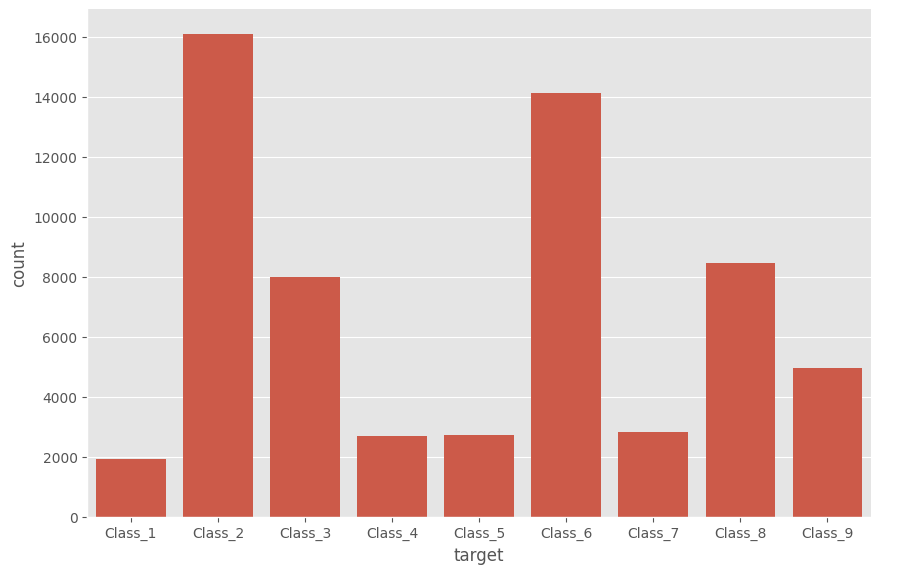

In [ ]:
g = sns.catplot(x='target',data=df_train,kind="count")
g.fig.set_size_inches(10,6)
# df_train['target'].value_counts()

In [ ]:
df_test.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,3,2,1,0,0,0,0,0,0,0,5,3,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,2,0,4,0,4,0,0,0,0,2,0,0,0,8,0,0,0,0,0,0,0,0,2,0,4,0,4,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,6,8,0,0,0,0,0,0,0,0,0,0,0,2,0,0,4,0,2,0,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,0,7,1,0,0,0,7,0,2,0,0,0,4,0,0,0,1,1,2,0,0,0,0,0,0,1,0,0,2,0,0,0,1,0,1,0,4,0,2,3,0,0,0,0,10,1,0,2,0,0,1,6,1,1,0,0,1,1,1,2,0,0,2,0,0,0,0,0,0,0,6,0,2,0,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,21,3,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,9,0,0,2,0,0,0,0,6,0,8,0,0,0,0,1,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,4,0,5,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9,0,0


Tanto en la base de datos de testeo como la de entrenamiento vemos que los valores son muy dispersos (sparse), con un elevado número de ceros.

In [ ]:
np.unique(df_train[features].values.flatten(),return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 119, 121, 123, 125, 127, 130, 131, 132, 137, 139, 145, 148,
        149, 158, 160, 161, 165, 170, 171, 172, 180, 181, 231, 252, 253,
        263, 281, 283, 287, 311, 323, 325, 352]),
 array([4565838,  595789,  227816,  106951,   66006,   40568,   30343,
          22321,   17639,   13326,   11271,    8394,    7670,    5740,
     

Visualizamos en un *boxplot* cada feature según las clases de salida. En este caso, fijamos el limite superior a 15 para ver con más detenimiento los diagramas de cajas.

  0%|          | 0/2 [00:00<?, ?it/s]

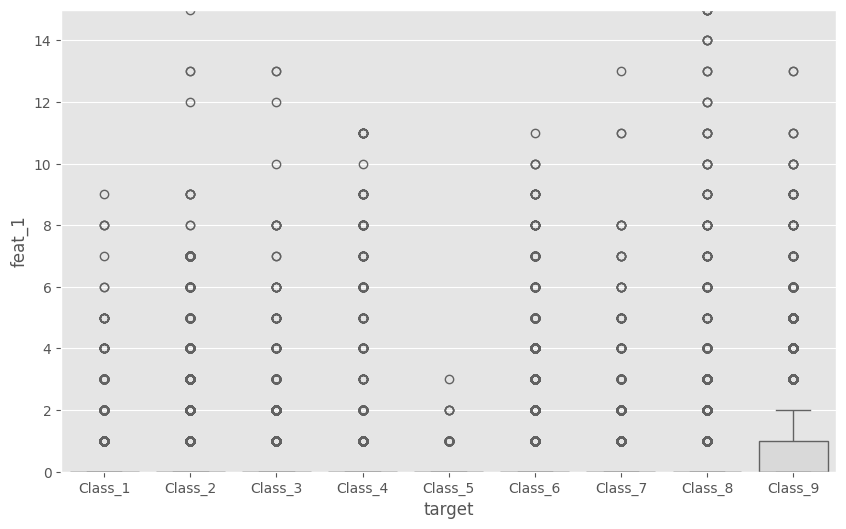

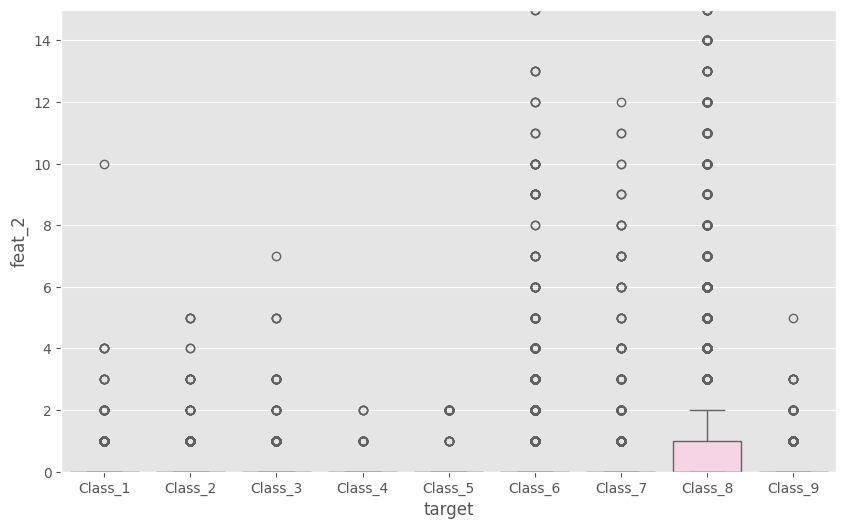

In [ ]:
import warnings
warnings.filterwarnings('ignore')
num_vars = 2 #len(features) # max features len(features)
for name_feat in tqdm(features[:num_vars]):
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x='target', y=name_feat, palette='Set3', data=df_train)
    ax.set_ylim([0, 15])

## Preprocesado de la Base de Datos

Aunque a los árboles no les suele afectar en demasía que las variables tengan diferentes rangos, vamos a tipificar los datos con *Z-Score* por si vamos a usar otros algoritmos supervisados **basados en distancias**, como KNN, o no supervisados, como clústering.

In [9]:
# Estandarizamos las BD
scaler = StandardScaler()
X_train = df_train_reduc[features].values
X_valid = df_valid_reduc[features].values
X_test = df_test_reduc[features].values
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Obtenemos los targets
y_train = df_train_reduc['target_num'].values
y_valid = df_valid_reduc['target_num'].values
y_test = df_test_reduc['target_num'].values

In [10]:
print("Verificamos que las TARGETS estan estratificadas")
print(np.round(np.bincount(y_train)/len(y_train),3))
print(np.round(np.bincount(y_valid)/len(y_valid),3))
print(np.round(np.bincount(y_test)/len(y_test),3))

Verificamos que las TARGETS estan estratificadas
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.044 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.043 0.044 0.229 0.046 0.137 0.08 ]


## Modelos Binarios de la Clase 2. Ejemplo con Random Forest

Vamos a desarrollar modelos clasificadores binarios de la clase 2 (Class_2) frente a las otras clases existentes. Para ello, creamos una clase binaria resultado de combinar todas las clases que no son de la clase 2 como 0, y 1 si pertenecen a la clase 2.

In [11]:
y_train_class2 = np.zeros_like(y_train.copy(), dtype=int)
# La clase 2 tiene el valor 1
y_train_class2[y_train==1] = 1
y_valid_class2 = np.zeros_like(y_valid.copy(), dtype=int)
y_valid_class2[y_valid==1] = 1
y_test_class2 = np.zeros_like(y_test.copy(), dtype=int)
y_test_class2[y_test==1] = 1

print('Porcentaje en las tres BD')
print(np.round(np.bincount(y_train_class2)/len(y_train_class2),3))
print(np.round(np.bincount(y_valid_class2)/len(y_valid_class2),3))
print(np.round(np.bincount(y_test_class2)/len(y_test_class2),3))

Porcentaje en las tres BD
[0.739 0.261]
[0.739 0.261]
[0.739 0.261]


### Métrica LogLoss

Inicialmente, vamos a buscar a hacer una exploración rápida con el algoritmo RandomForest que optimice el **logloss()**.

Esta métrica es una de las métricas más usadas en clasificación.

En clasificación multiclase o multilabel, se define como:

![](https://i.stack.imgur.com/NEmt7.png)

donde
- *N* = número de instancias.
- *M* = número de clases.
- $y_{ij}$ = probabilidad real de la clase $j$ correspondiente a la instancia $i$. Suele ser 1 o 0, aunque puede tener cualquier otro valor entre 0 y 1.
- $p_{ij}$ = probabilidad estimada por el clasificador para la clase $j$ de la instancia $i$.

Mientras que en clasificación binaria se suele usar:

![](https://miro.medium.com/max/656/1*wilGXrItaMAJmZNl6RJq9Q.png)

En ambos casos, cuanto más pequeño sea el valor de la métrica, mejor clasificación tendremos.

---

**Para profundizar, ver los siguiente videos**:

- *Understanding Binary Cross-Entropy / Log Loss in 5 minutes: a visual explanation*: https://www.youtube.com/watch?v=DPSXVJF5jIs
- *What is Log loss in machine learning|| How to calculate log loss in ML?*: https://www.youtube.com/watch?v=YbhzM2wxuBg

---

### Modelo RandomForest

Vamos a comenzar a estudiar **cómo modelizar el problema usando el algoritmo *RandomForestClassifier()* que es fácil de utilizar, potente y robusto**: . Más adelante, probaremos otros algoritmos más avanzados basados en Gradient Boosting Machines (GBM) como *LightGBM* o *XGBoost*.




---

**Para profundizar ver los siguiente videos**:

- *Random Forest Algorithm Clearly Explained!*: https://www.youtube.com/watch?v=v6VJ2RO66Ag
- *Random Forest Classification | Machine Learning | Python*: https://www.youtube.com/watch?v=3NdH3egUjpM
- *StatQuest: Random Forests Part 1 - Building, Using and Evaluating*: https://www.youtube.com/watch?v=J4Wdy0Wc_xQ
- *StatQuest: Random Forests Part 2: Missing data and clustering*: https://www.youtube.com/watch?v=sQ870aTKqiM

---



  0%|          | 0/9 [00:00<?, ?it/s]

<Axes: xlabel='n_estimators'>

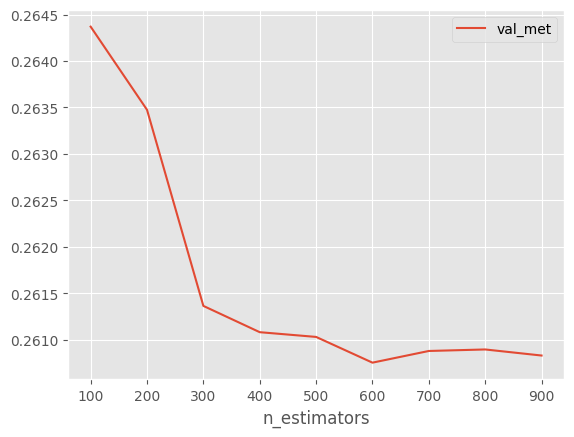

In [ ]:
res = []
for n_estimators in tqdm(np.arange(100, 1000, 100)):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=4567)
    rf_model.fit(X_train_scaled, y_train_class2)
    val_met = log_loss(y_valid_class2, rf_model.predict_proba(X_valid_scaled)[:,1])
    res.append(dict(n_estimators=n_estimators, val_met=val_met))
res = pd.DataFrame(res)
res.plot(x='n_estimators', y='val_met')

In [ ]:
best_model = res.iloc[res.val_met.argmin()]
print(best_model)
best_estimators = best_model.n_estimators.astype(int)

# Logloss con la de testeo
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
rf_model.fit(X_train_scaled, y_train_class2)
tst_met = log_loss(y_test_class2, rf_model.predict_proba(X_test_scaled)[:,1])
print("Logloss con la base de datos de testeo=", tst_met)

n_estimators    600.000000
val_met           0.260754
Name: 5, dtype: float64
Logloss con la base de datos de testeo= 0.26022590420620706


### Calibrado de las Probabilidades

Así mismo, podemos ver la diferencia de calibrar las predicciones del clasificador o no. Muchos algoritmos no presentan una probabilidad equilibrada y **cuando se usan métricas del tipo *LogLoss*, es necesario equilibrar la probabilidad de las predicciones**.

Por ejemplo, si agrupamos los casos en los que el modelo estima una probabilidad cercana al 80%, el 80% de los targets deberían ser 1.0. Es decir, un modelo calibrado tendrá la misma proporción $\hat{p}$ de targets positivos en aquellas instancias clasificadas con una probabilidad cercana estimada $\hat{p}$.

Sin embargo, muchos algoritmos que no son probabilisticos como, por ejemplo, los árboles o las máquinas vectores soporte, realizan unas estimaciones de probabilidad que no están equilibradas.

*scikit-learn* dispone de la función *CalibratedClassifierCV()* que permite calcular un modelo y posteriormente [calibrar las probalidades](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) con [regresión isotónica](https://en.wikipedia.org/wiki/Isotonic_regression) o regresión logística.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_calibration_curve_002.png)

---

**Para profundizar ver los siguiente videos**:

- *Probability Calibration : Data Science Concepts*: https://www.youtube.com/watch?v=AunotauS5yI
- *Probability Calibration for Classification (Platt, isotonic, logistic and beta)*: https://www.youtube.com/watch?v=O5undKIazqs
- *Probability Calibration Workshop - Lesson 1*: https://www.youtube.com/watch?v=QUXfYgGlwtU

---

In [ ]:
def entrena_model_hold_out(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_log_loss = log_loss(y_valid, preds, eps=1e-15, normalize=True)
    return dict(log_loss=metrica_log_loss)

In [ ]:
%%time
# Comprobamos el grado de generalización del modelo con y sin calibración
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
print(f'Modelo Sin Calibrar LogLossVal={metricas["log_loss"]}')

metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
print(f'Modelo Con Calibración LogLossVal={metricas["log_loss"]}')

Modelo Sin Calibrar LogLossVal=0.26022590420620706
Modelo Con Calibración LogLossVal=0.2500473681576325
CPU times: user 2min 44s, sys: 2.15 s, total: 2min 46s
Wall time: 1min 50s


### EJERCICIO 1

Realizar las tareas siguientes y responder en un Informe PDF a las respuestas planteadas:

- Buscar el mejor modelo RF modificando *n_estimators* entre 100 y 1500 (con paso 100) que optimice las siguientes cinco métricas con la base de datos de validación: *Accuracy*, *F1-Score*, *Kappa*, *AUC* y *logloss*. Probar para cada métrica *sin calibrar* y *calibrando*.
- Rellenar **la tabla de abajo con el mejor número de estimadores (calibrando o sin calibrar)** y para cada una de las métricas (presentar el resultado para la base de datos de validación y la de testeo).
- Analizar la tabla y explicar los resultados.
- Explicar **el significado de cada métrica** y analizar por qué funciona mejor un método u otro para cada una de ellas.
- Pon ejemplos de la vida real de cuándo utilizar una métrica u otra.

NOTA: Utilizar la misma semilla aleatoria usada en los ejemplos. Pregunta: ¿Qué pasa si cambiamos la semilla aleatoria?  

    
| Métrica | *n_estimators* | Calibrado | Val | Tst |
|---------|-----------|-----------|-----|-----|
| ACC |100|Si|0.00|0.05|
| F1  |200|No|0.00|0.05|
| Kappa |150|Si|0.00|0.05|
| AUC   |200|No|0.00|0.05|
| LogLoss |250|Si|0.00|0.05|


## Respuesta Ejercicio 1

In [15]:
# modifico la funcion y añado la parte correspondiente a testeo para poder rellenar la tabla del ejercicio.
def entrena_model_hold_out_ej1(model, X_train, y_train, X1_valid, X2_valid, y1_valid, y2_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds1 = calibrated_clf.predict_proba(X1_valid)[:,1]
        preds2 = calibrated_clf.predict_proba(X2_valid)[:,1]

    else:
        model.fit(X_train, y_train)
        preds1 = model.predict_proba(X1_valid)[:,1]
        preds2 = model.predict_proba(X2_valid)[:,1]


    metricas={}
    metricas['log_loss_val'] = log_loss(y1_valid,preds1,eps=1e-15, normalize=True)
    metricas['log_loss_test'] = log_loss(y2_valid,preds2,eps=1e-15, normalize=True)
    metricas['accuracy_val'] = accuracy_score(y1_valid, np.round(preds1))
    metricas['accuracy_test'] = accuracy_score(y2_valid, np.round(preds2))
    metricas['f1_score_val'] = f1_score(y1_valid, np.round(preds1))
    metricas['f1_score_test'] = f1_score(y2_valid, np.round(preds2))
    metricas['kappa_val'] = cohen_kappa_score(y1_valid, np.round(preds1))
    metricas['kappa_test'] = cohen_kappa_score(y2_valid, np.round(preds2))
    metricas['auc_val'] = roc_auc_score(y1_valid, preds1)
    metricas['auc_test'] = roc_auc_score(y2_valid, preds2)


    return metricas

In [16]:
for n in tqdm(np.arange(100, 1501, 100)):
  modelRF = RandomForestClassifier(n_estimators=n, n_jobs=-1, random_state=4567)
  print(f'n_estimators={n}\n')
  metricas = entrena_model_hold_out_ej1(modelRF, X_train_scaled, y_train_class2, X_valid_scaled, X_test_scaled, y_valid_class2, y_test_class2, calibra=False)
  print(f'Modelo Sin Calibrar\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Testeo:     LogLossVal = {metricas["log_loss_test"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Testeo:     Accuracy   = {metricas["accuracy_test"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Testeo:     F1-Score   = {metricas["f1_score_test"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Testeo:     Kappa      = {metricas["kappa_test"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'
          f'Testeo:     AUC        = {metricas["auc_test"]}\n'

          '\n')
  metricas = entrena_model_hold_out_ej1(modelRF, X_train_scaled, y_train_class2, X_valid_scaled, X_test_scaled, y_valid_class2, y_test_class2, calibra=True)
  print(f'Modelo Calibrado\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Testeo:     LogLossVal = {metricas["log_loss_test"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Testeo:     Accuracy   = {metricas["accuracy_test"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Testeo:     F1-Score   = {metricas["f1_score_test"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Testeo:     Kappa      = {metricas["kappa_test"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'
          f'Testeo:     AUC        = {metricas["auc_test"]}\n'

          '\n')

  0%|          | 0/15 [00:00<?, ?it/s]

n_estimators=100

Modelo Sin Calibrar
Validacion: LogLossVal = 0.26428851124187897
Testeo:     LogLossVal = 0.26177916511017735
Validacion: Accuracy   = 0.8823529411764706
Testeo:     Accuracy   = 0.8822863915526344
Validacion: F1-Score   = 0.76696542893726
Testeo:     F1-Score   = 0.7684645544134789
Validacion: Kappa      = 0.688387551616477
Testeo:     Kappa      = 0.6896133758963876
Validacion: AUC        = 0.9496910298224661
Testeo:     AUC        = 0.9501879297898371


Modelo Calibrado
Validacion: LogLossVal = 0.25346580276740677
Testeo:     LogLossVal = 0.25160591952347766
Validacion: Accuracy   = 0.8792286145227322
Testeo:     Accuracy   = 0.8788923607369895
Validacion: F1-Score   = 0.78101191638992
Testeo:     F1-Score   = 0.7811952501459997
Validacion: Kappa      = 0.6979866379593342
Testeo:     Kappa      = 0.6978651487291327
Validacion: AUC        = 0.9486030871441077
Testeo:     AUC        = 0.9495782246217586


n_estimators=200

Modelo Sin Calibrar
Validacion: LogLossVal =

### EJERCICIO 2

Repetir el ejercicio anterior pero usando los siguientes algoritmos (tocando solo el hiperparámetro más importante del algoritmo):
- LogisticRegression(*C* = cost)
- KNeighborsClassifier(*n_neighbors* = num_vecinos)
- MLPClassifier(*hidden_layer_sizes* = (num_neuronas,), *solver* = 'lbfgs')
- DecisionTreeClassifier(*max_depth* = max_profundidad)
- SVC(*C*= cost, *kernel*='rbf')


**Rellenar una tabla indicando para cada algoritmo el valor obtenido de la métrica y si ha sido conveniente calibrar o no (entre parentesis).**

| Métrica | LOG | KNN | MLP | DTC | SVC |
|---------|-----|-----|-----|----|-----|
| ACC     |0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| F1     |0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| Kappa     |0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| AUC     |0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| LogLoss     |0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|


Analiza la tabla y extrae tus propias conclusiones.



In [12]:
def entrena_model_hold_out_ej2(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]

    metricas = {}
    metricas['log_loss_val'] = log_loss(y_valid,preds,eps=1e-15, normalize=True)
    metricas['accuracy_val'] = accuracy_score(y_valid, np.round(preds))
    metricas['f1_score_val'] = f1_score(y_valid, np.round(preds))
    metricas['kappa_val'] = cohen_kappa_score(y_valid, np.round(preds))
    metricas['auc_val'] = roc_auc_score(y_valid, preds)


    return metricas



Regresión Logistica

In [ ]:
lista = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 750.0, 1000.0]

for c in lista:
  modelLR = LogisticRegression(C=c, n_jobs=-1, random_state=4567)
  print(f'C={c}\n')
  metricas = entrena_model_hold_out_ej2(modelLR, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=False)
  print(f'Modelo Sin Calibrar\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')
  metricas = entrena_model_hold_out_ej2(modelLR, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=True)
  print(f'Modelo Calibrado\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')

C=0.001

Modelo Sin Calibrar
Validacion: LogLossVal = 0.35395074927889214
Validacion: Accuracy   = 0.8132406808877397
Validacion: F1-Score   = 0.5931228729022414
Validacion: Kappa      = 0.4747832352465663
Validacion: AUC        = 0.8994848483643458


Modelo Calibrado
Validacion: LogLossVal = 0.3348623700501326
Validacion: Accuracy   = 0.8355957767722474
Validacion: F1-Score   = 0.7295285359801488
Validacion: Kappa      = 0.6148671290110497
Validacion: AUC        = 0.9006264824832597


C=0.01

Modelo Sin Calibrar
Validacion: LogLossVal = 0.3275406764878878
Validacion: Accuracy   = 0.835757379875027
Validacion: F1-Score   = 0.6811669978040364
Validacion: Kappa      = 0.5705750701543217
Validacion: AUC        = 0.9076205514054458


Modelo Calibrado
Validacion: LogLossVal = 0.324402892803824
Validacion: Accuracy   = 0.8385046326222797
Validacion: F1-Score   = 0.7288350217076699
Validacion: Kappa      = 0.6163948457244114
Validacion: AUC        = 0.9084926814552279


C=0.1

Modelo Sin Cali

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
lista = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29] #usar solo impares para ebitar el "empate"

for n in lista:
  modelKNN = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
  print(f'n_neighbors={n}\n')
  metricas = entrena_model_hold_out_ej2(modelKNN, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=False)
  print(f'Modelo Sin Calibrar\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')
  metricas = entrena_model_hold_out_ej2(modelKNN, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=True)
  print(f'Modelo Calibrado\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')

n_neighbors=3

Modelo Sin Calibrar
Validacion: LogLossVal = 1.6337517453275876
Validacion: Accuracy   = 0.8512174100409394
Validacion: F1-Score   = 0.7191376855806386
Validacion: Kappa      = 0.6179806362378977
Validacion: AUC        = 0.8987590310674988


Modelo Calibrado
Validacion: LogLossVal = 0.31990767591954794
Validacion: Accuracy   = 0.8508403361344538
Validacion: F1-Score   = 0.71544548350632
Validacion: Kappa      = 0.6143810583745564
Validacion: AUC        = 0.9193394896907613


n_neighbors=5

Modelo Sin Calibrar
Validacion: LogLossVal = 0.8683691457221329
Validacion: Accuracy   = 0.8521870286576169
Validacion: F1-Score   = 0.7245533025496889
Validacion: Kappa      = 0.6236616393865843
Validacion: AUC        = 0.9172663930534588


Modelo Calibrado
Validacion: LogLossVal = 0.30258440716103235
Validacion: Accuracy   = 0.8521870286576169
Validacion: F1-Score   = 0.7302929034794574
Validacion: Kappa      = 0.6288309178743962
Validacion: AUC        = 0.9271824015349139


n_neighb

In [17]:
lista = [(10,), (50,), (100,), (200,), (300,), (10, 10), (50, 50), (100, 100), (200, 200), (300, 300), (10, 10, 10), (50, 50, 50), (100, 100, 100), (200, 200, 200), (300, 300, 300)]


for hl in lista:
  modelMLP = MLPClassifier(hidden_layer_sizes=hl, solver = 'adam', random_state=4567,max_iter=1000)
  print(f'hidden_layer_sizes={hl}\n')
  metricas = entrena_model_hold_out_ej2(modelMLP, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=False)
  print(f'Modelo Sin Calibrar\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')
  metricas = entrena_model_hold_out_ej2(modelMLP, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=True)
  print(f'Modelo Calibrado\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')

hidden_layer_sizes=(10,)

Modelo Sin Calibrar
Validacion: LogLossVal = 0.2911219159222945
Validacion: Accuracy   = 0.8602133160956691
Validacion: F1-Score   = 0.7367353150045652
Validacion: Kappa      = 0.6416249168775916
Validacion: AUC        = 0.9345441013012353


Modelo Calibrado
Validacion: LogLossVal = 0.2874077225170641
Validacion: Accuracy   = 0.8586511527687998
Validacion: F1-Score   = 0.7634331049404977
Validacion: Kappa      = 0.6649886919092435
Validacion: AUC        = 0.9401680556399075


hidden_layer_sizes=(50,)

Modelo Sin Calibrar
Validacion: LogLossVal = 0.5606659385560864
Validacion: Accuracy   = 0.8598362421891834
Validacion: F1-Score   = 0.7292967124427799
Validacion: Kappa      = 0.634738520919742
Validacion: AUC        = 0.9322091073215453


Modelo Calibrado
Validacion: LogLossVal = 0.2880509400494604
Validacion: Accuracy   = 0.8620986856280974
Validacion: F1-Score   = 0.7699083228473844
Validacion: Kappa      = 0.6738378653853154
Validacion: AUC        = 0.941568

In [18]:
lista = [(10,), (50,), (100,), (200,), (300,), (10, 10), (50, 50), (100, 100), (200, 200), (300, 300), (10, 10, 10), (50, 50, 50), (100, 100, 100), (200, 200, 200), (300, 300, 300)]


for hl in lista:
  modelMLP = MLPClassifier(hidden_layer_sizes=hl, solver = 'lbfgs', random_state=4567,max_iter=10000)
  print(f'hidden_layer_sizes={hl}\n')
  metricas = entrena_model_hold_out_ej2(modelMLP, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=False)
  print(f'Modelo Sin Calibrar\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')
  metricas = entrena_model_hold_out_ej2(modelMLP, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=True)
  print(f'Modelo Calibrado\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')

hidden_layer_sizes=(10,)

Modelo Sin Calibrar
Validacion: LogLossVal = 0.305644923650824
Validacion: Accuracy   = 0.8626373626373627
Validacion: F1-Score   = 0.7441813804173356
Validacion: Kappa      = 0.6504064478668399
Validacion: AUC        = 0.9362132129656943


Modelo Calibrado
Validacion: LogLossVal = 0.2873994404094116
Validacion: Accuracy   = 0.8493320405085111
Validacion: F1-Score   = 0.7592321597658603
Validacion: Kappa      = 0.6540097151666162
Validacion: AUC        = 0.9429702532699586


hidden_layer_sizes=(50,)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Modelo Sin Calibrar
Validacion: LogLossVal = 3.5775131946052445
Validacion: Accuracy   = 0.8482008187890541
Validacion: F1-Score   = 0.7063359733222175
Validacion: Kappa      = 0.603991006183249
Validacion: AUC        = 0.9180037108173739




KeyboardInterrupt: 

In [18]:
def entrena_model_hold_out_ej2(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        decision_scores = model.decision_function(X_valid)
        preds = (decision_scores > 0).astype(int)

    metricas = {}
    metricas['log_loss_val'] = log_loss(y_valid,preds,eps=1e-15, normalize=True)
    metricas['accuracy_val'] = accuracy_score(y_valid, np.round(preds))
    metricas['f1_score_val'] = f1_score(y_valid, np.round(preds))
    metricas['kappa_val'] = cohen_kappa_score(y_valid, np.round(preds))
    metricas['auc_val'] = roc_auc_score(y_valid, preds)


    return metricas


In [14]:
lista = [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

for md in lista:
  modelTree = DecisionTreeClassifier(max_depth=md, random_state=4567)
  print(f'max_depth={md}\n')
  metricas = entrena_model_hold_out_ej2(modelTree, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=False)
  print(f'Modelo Sin Calibrar\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')
  metricas = entrena_model_hold_out_ej2(modelTree, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=True)
  print(f'Modelo Calibrado\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')

max_depth=None

Modelo Sin Calibrar
Validacion: LogLossVal = 5.866304013992507
Validacion: Accuracy   = 0.8301551389786684
Validacion: F1-Score   = 0.6777721001532958
Validacion: Kappa      = 0.5624801038274114
Validacion: AUC        = 0.7833683453643131


Modelo Sin Calibrar
Validacion: LogLossVal = 0.39217975306978164
Validacion: Accuracy   = 0.8158801982331394
Validacion: F1-Score   = 0.6366921768707482
Validacion: Kappa      = 0.5135177158385242
Validacion: AUC        = 0.8668493471048527


Modelo Calibrado
Validacion: LogLossVal = 0.3663234379936237
Validacion: Accuracy   = 0.8269230769230769
Validacion: F1-Score   = 0.660107902253253
Validacion: Kappa      = 0.5440939220392701
Validacion: AUC        = 0.8898736888714402


max_depth=10

Modelo Sin Calibrar
Validacion: LogLossVal = 0.8235090335977604
Validacion: Accuracy   = 0.8309092867916398
Validacion: F1-Score   = 0.6772900174771256
Validacion: Kappa      = 0.5627371173784431
Validacion: AUC        = 0.8793031328507444


Modelo

In [ ]:
lista = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 750.0, 1000.0]

for c in lista:
  modelSVC = SVC(C=c, kernel='rbf', random_state=4567)
  print(f'C={c}\n')
  metricas = entrena_model_hold_out_ej2(modelSVC, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=False)
  print(f'Modelo Sin Calibrar\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')
  metricas = entrena_model_hold_out_ej2(modelSVC, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=True)
  print(f'Modelo Calibrado\n'
          f'Validacion: LogLossVal = {metricas["log_loss_val"]}\n'
          f'Validacion: Accuracy   = {metricas["accuracy_val"]}\n'
          f'Validacion: F1-Score   = {metricas["f1_score_val"]}\n'
          f'Validacion: Kappa      = {metricas["kappa_val"]}\n'
          f'Validacion: AUC        = {metricas["auc_val"]}\n'

          '\n')

C=0.001

Modelo Sin Calibrar
Validacion: LogLossVal = 8.997496371783452
Validacion: Accuracy   = 0.7394957983193278
Validacion: F1-Score   = 0.0
Validacion: Kappa      = 0.0
Validacion: AUC        = 0.5


Modelo Calibrado
Validacion: LogLossVal = 0.3544229821728835
Validacion: Accuracy   = 0.8306938159879337
Validacion: F1-Score   = 0.6971769920030831
Validacion: Kappa      = 0.5804326731618121
Validacion: AUC        = 0.8931530542107464


C=0.01

Modelo Sin Calibrar
Validacion: LogLossVal = 6.361178413677082
Validacion: Accuracy   = 0.8158263305322129
Validacion: F1-Score   = 0.5906859810846402
Validacion: Kappa      = 0.4756628300940907
Validacion: AUC        = 0.716823163395744


Modelo Calibrado
Validacion: LogLossVal = 0.35285794126443637
Validacion: Accuracy   = 0.8324175824175825
Validacion: F1-Score   = 0.6991586887148246
Validacion: Kappa      = 0.5836928983243541
Validacion: AUC        = 0.8951557697971315


C=0.1

Modelo Sin Calibrar
Validacion: LogLossVal = 5.23000481507687

## Balanceo de Clases

Algunas métricas pueden mejorarse mediante el balanceo de las clases que consiste en **equilibrar el número de casos de cada clase**:

- Sobremuestreando la clase minoritaria (*oversampling*).
- Submuestrando la clase mayoritaria (*subsampling*).
- Creando nuevos casos de la clase minoritaria mediante algoritmos como SMOTE.

Ver: https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data/notebook

Otra forma, más habitual y eficiente, **es aplicar diferentes pesos a cada una de las clases**, de forma que la clase minoritaria tenga mayor peso que la mayoritaria a la hora de construir el modelo (habitualmente la función *loss* del algoritmo incorpora los pesos de cada clase en la propia fórmula de modo que el balanceo se realiza directamente al calcular dicho coste).

Vamos a ver un ejemplo para mejora el *accuracy*. Como se puede ver en la gráfica, la base de datos está desbalanceada.

is_class_2
False    18303
True      6449
Name: count, dtype: int64

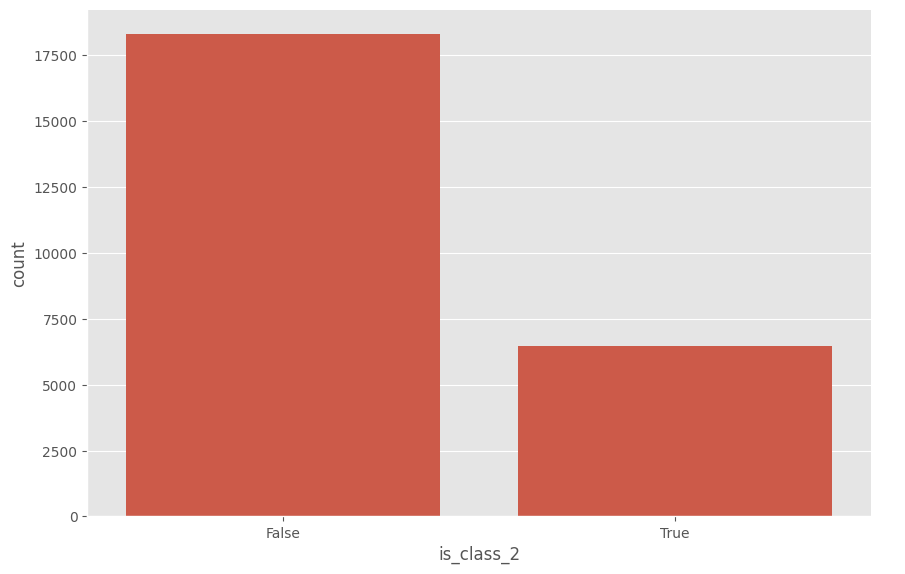

In [19]:
X_tmp = df_train_reduc.copy()
X_tmp['is_class_2'] = (y_train_class2==1)
g = sns.catplot(x='is_class_2', data=X_tmp, kind='count')
g.fig.set_size_inches(10,6)
X_tmp['is_class_2'].value_counts()

In [20]:
def entrena_model_hold_out(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train_class2)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_log_loss = log_loss(y_valid, preds, eps=1e-15, normalize=True)
    metrica_acc = accuracy_score(y_valid, preds>0.50)
    return dict(log_loss=metrica_log_loss, acc=metrica_acc)

Vamos a probar Balancear las clases con la librería *imblearn* usando el modelo Logistico.

**Es importante entender que la base de datos de validación y testeo NO hay que modificarlas, solo la de entrenamiento. Si modificamos las bases de datos de validación o testeo estamos desvirtuando toda la validación de los modelos**

In [21]:
# !python -m pip install imblearn

In [22]:
log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico Sin Balancear ACC={metricas["acc"]}')

Modelo Logistico Sin Balancear ACC=0.839258780435251


In [23]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
oversamp = RandomOverSampler(random_state=1234)
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con OverSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [18303 18303]
Modelo Logistico con OverSampling ACC=0.8198664081017022


In [24]:
oversamp = RandomUnderSampler(random_state=1234)
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con UnderSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [6449 6449]
Modelo Logistico con UnderSampling ACC=0.818304244774833


Vemos que parece que NO mejora el ACC con ninguno de los dos. Quizás balancear al 100% las clases es demasiado y puede ser interesante hacer un balanceo con un ratio que no sea del 100%. Para ello se puede usar la opción *sampling_strategy* que permite indicar el número de casos de cada clase que queremos que muestree.

Incrementamos levemente el número de casos de la clase 2 (clase minoritaria)

In [25]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
oversamp = RandomOverSampler(random_state=1234, sampling_strategy={0:18303, 1:6500})
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con un ligero OverSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [18303  6500]
Modelo Logistico con un ligero OverSampling ACC=0.8393126481361776


Existen otros métodos como SMOTE que permite realizar nuevas instancias de la clase minoritaria en base a búsqueda por K-Vecinos (ver ejemplos en https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).


Otra forma, muy utilizada e incluso más eficiente, es la del siguiente ejemplo donde vemos otra forma de tratar el desbalanceo mediante el uso de pesos diferentes para cada clase.        

In [26]:
%%time
# Se asigna un peso a cada clase inversamente proporcional a la fecuencia de cada clase
print('Pesos asignados a cada clase:',len(y_train_class2)/(2*np.bincount(y_train_class2)))
log_model = LogisticRegression(C=1, class_weight='balanced',random_state=4567,n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico ajustando los Pesos ACC={metricas["acc"]}')

Pesos asignados a cada clase: [0.6761733  1.91905722]
Modelo Logistico ajustando los Pesos ACC=0.8197048049989226
CPU times: user 67.2 ms, sys: 30.5 ms, total: 97.7 ms
Wall time: 1.83 s


Igual que en el caso anterior, los pesos pueden ser ajustados manualmente para que el balanceo sea menos drástico.

In [27]:
%%time
# Se asigna un peso a cada clase inversamente proporcional a la fecuencia de cada clase
log_model = LogisticRegression(C=1, class_weight={0:0.6761, 1:0.7}, random_state=4567,n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico ajustando los Pesos ACC={metricas["acc"]}')

Modelo Logistico ajustando los Pesos ACC=0.8393665158371041
CPU times: user 59.3 ms, sys: 33.6 ms, total: 92.9 ms
Wall time: 1.89 s


### EJERCICIO  3

Elige el mejor algoritmo para cada una de las métricas obtenidas en la tabla del ejercicio 2 e intenta mejorar los resultados obtenidos con alguna de las técnicas de muestreo anteriores. Rellena la siguiente tabla.



| Métrica | Algoritmo | Original | Nuevo | Método Usado |
|---------|-----------|----------|-------|--------------|
| ACC     |MLP|0.00|0.05|Undersampling|
| F1     |SVC|0.00|0.05|Smote|
| Kappa     |LOG|0.00|0.05|Undersampling (0=10000,1=7000)|
| AUC     |DTC|0.00|0.05|Oversampling|
| LogLoss     |MLP|0.00|0.05|No se ha podido|

In [33]:
def entrena_model_hold_out_ej3(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]

    metricas = {}
    metricas['log_loss_val'] = log_loss(y_valid,preds,eps=1e-15, normalize=True)
    metricas['accuracy_val'] = accuracy_score(y_valid, np.round(preds))
    metricas['f1_score_val'] = f1_score(y_valid, np.round(preds))
    metricas['kappa_val'] = cohen_kappa_score(y_valid, np.round(preds))
    metricas['auc_val'] = roc_auc_score(y_valid, preds)


    return metricas


In [35]:
from sklearn.neural_network import MLPClassifier

# OverSampling
oversamp = RandomOverSampler(random_state=4567)
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)

modelMLPEj3 = MLPClassifier(hidden_layer_sizes=(300, 300, 300), solver='adam', random_state=4567, max_iter=1000)
metricas = entrena_model_hold_out_ej3(modelMLPEj3, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=True)
print(f'Modelo MLP con OverSampling F1-Score={metricas["f1_score_val"]}')
print(f'Modelo MLP con OverSampling Kappa={metricas["kappa_val"]}')
print(f'Modelo MLP con OverSampling AUC={metricas["auc_val"]}')
print(f'Modelo MLP con OverSampling LogLoss={metricas["log_loss_val"]}')


# UnderSampling
undersamp = RandomUnderSampler(random_state=4567)
X_train_resampled, y_train_resampled = undersamp.fit_resample(X_train_scaled, y_train_class2)

modelMLPEj3 = MLPClassifier(hidden_layer_sizes=(300, 300, 300), solver='adam', random_state=4567, max_iter=1000)
metricas = entrena_model_hold_out_ej3(modelMLPEj3, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=True)
print(f'Modelo MLP con UnderSampling F1-Score={metricas["f1_score_val"]}')
print(f'Modelo MLP con UnderSampling Kappa={metricas["kappa_val"]}')
print(f'Modelo MLP con UnderSampling AUC={metricas["auc_val"]}')
print(f'Modelo MLP con UnderSampling LogLoss={metricas["log_loss_val"]}')


Modelo MLP con OverSampling F1-Score=0.7662231320368477
Modelo MLP con OverSampling Kappa=0.6827488963747868
Modelo MLP con OverSampling AUC=0.943081733239534
Modelo MLP con OverSampling LogLoss=0.2718286175774431
Modelo MLP con UnderSampling F1-Score=0.7553641092327699
Modelo MLP con UnderSampling Kappa=0.6422250189779856
Modelo MLP con UnderSampling AUC=0.9417491853421601
Modelo MLP con UnderSampling LogLoss=0.3069348984119906


In [36]:
from sklearn.neural_network import MLPClassifier

# OverSampling
oversamp = RandomOverSampler(random_state=4567)
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)

modelMLPEj3 = MLPClassifier(hidden_layer_sizes=(300, 300), solver='adam', random_state=4567, max_iter=1000)
metricas = entrena_model_hold_out_ej3(modelMLPEj3, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo MLP con OverSampling ACC={metricas["accuracy_val"]}')



# UnderSampling
undersamp = RandomUnderSampler(random_state=4567)
X_train_resampled, y_train_resampled = undersamp.fit_resample(X_train_scaled, y_train_class2)

modelMLPEj3 = MLPClassifier(hidden_layer_sizes=(300, 300), solver='adam', random_state=4567, max_iter=1000)
metricas = entrena_model_hold_out_ej3(modelMLPEj3, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo MLP con UnderSampling ACC={metricas["accuracy_val"]}')


Modelo MLP con OverSampling ACC=0.8682396035337212
Modelo MLP con UnderSampling ACC=0.8529950441715147


## ENTREGA

**Todos los pasos realizados deberán ser explicados con detalle en un documento PDF. El nombre del archivo deberá incluir lo siguiente 'PROYECTO3_NombreDelAlumnoSinAcentos.PDF'. Ejemplo: PROYECTO3A_PEPITO_PEREZ.PDF**

Si usas Colab, recuerde guardar sus cambios en su repositorio utilizando la opción "Save a copy in GitHub..." del menú File.